# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Amirmahdi Meighani



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


In [1]:
# Enter your information here
first_and_last_name = 'Alireza Mirrokni'
std_number = '401106617'

![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [2]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader
import warnings

warnings.filterwarnings("ignore")

Check your device. We recommend using GPU. You can use GPU with google colab.

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [4]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0)
    x_normalized = (x - mean) / np.sqrt(variance + epsilon)
    return gamma * x_normalized + beta

In [5]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [6]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

print("Transform Train:", transform_train)
print("Transform Test:", transform_test)

# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# TODO: create train data loader without shuffle with just half of the data
train_indices = list(range(len(train_set) // 2))
train_subset = Subset(train_set, train_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)

print("Total training samples:", len(train_set))
print("Subset training samples:", len(train_subset))

# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# TODO: create test
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
print("Validation samples:", len(val_set))

Transform Train: Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
)
Transform Test: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
)


100%|██████████| 170M/170M [00:05<00:00, 29.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Total training samples: 50000
Subset training samples: 25000
Files already downloaded and verified
Validation samples: 10000


Explain what we did in transfor train and tranform test:<br/>
*answer*


### `transform_train`
The `transform_train` pipeline applies a series of transformations to the training images. These transformations are designed to augment and normalize the data to improve model generalization:

1. **`transforms.RandomResizedCrop(224, scale=(0.5, 1.0))`**:
   - Randomly crops the input image to a size of 224x224 pixels.
   - The cropping scale is randomly chosen between 50% to 100% of the original image size.
   - This augments the dataset by introducing variations in how images are cropped.

2. **`transforms.RandomHorizontalFlip()`**:
   - Randomly flips the image horizontally with a probability of 0.5.
   - This helps the model become invariant to left-right orientation changes in images.

3. **`transforms.ToTensor()`**:
   - Converts the image from a PIL image or NumPy array to a PyTorch tensor.
   - Normalizes the pixel values to the range [0, 1].

4. **`transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])`**:
   - Normalizes the tensor by subtracting the dataset mean and dividing by the standard deviation for each channel (R, G, B).
   - The means and standard deviations are specific to the CIFAR-10 dataset.

---

### `transform_test`
The `transform_test` pipeline applies transformations for the validation/testing images. Unlike `transform_train`, it does not include augmentations since the goal is to evaluate the model on consistent and clean data:

1. **`transforms.Resize((224, 224))`**:
   - Resizes the input image to a fixed size of 224x224 pixels without cropping.
   - Ensures that all validation images have the same dimensions.

2. **`transforms.ToTensor()`**:
   - Converts the image from a PIL image or NumPy array to a PyTorch tensor.
   - Normalizes the pixel values to the range [0, 1].

3. **`transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])`**:
   - Normalizes the tensor using the dataset-specific mean and standard deviation for each channel.

---

### Key Differences Between `transform_train` and `transform_test`
- `transform_train` includes **data augmentation** techniques like random resizing and horizontal flipping to increase diversity in the training data.
- `transform_test` focuses on **standardization** without augmentation to provide consistent input for evaluation.


for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.


--- Displaying 32 images with shuffle=False ---


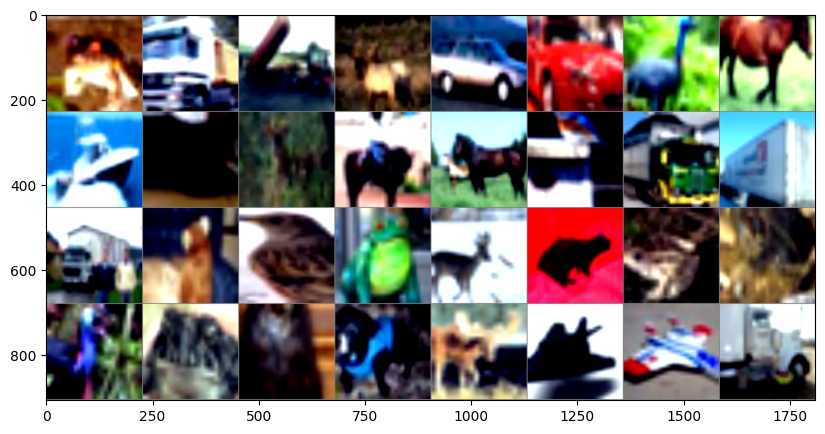

First 32 labels from the batch of 128 (shuffle=False): [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2]
All 128 labels in the batch (shuffle=False): [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9]



--- Displaying augmented images with shuffle=False ---


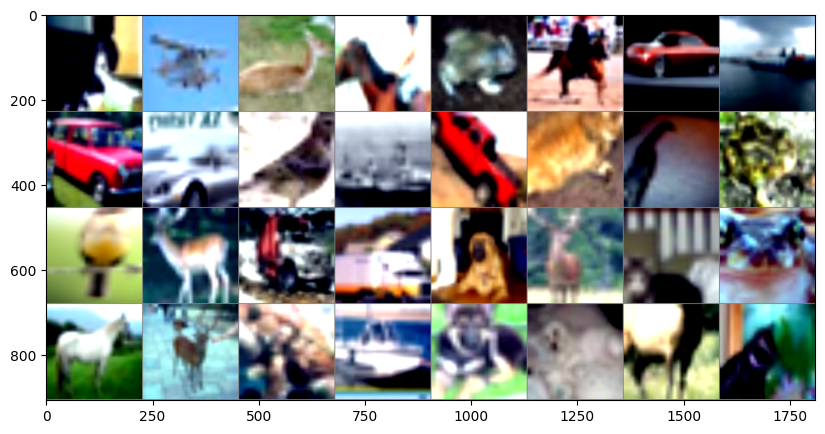

First 32 labels from the batch of 128 (after augmentation): [5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3]
All 128 labels in the batch (after augmentation): [5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1]



--- Displaying 32 images with shuffle=True ---


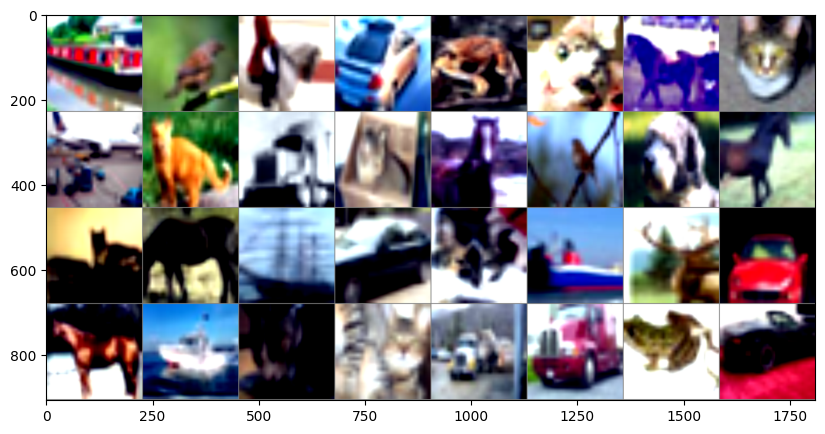

First 32 labels from the batch of 128 (shuffle=True): [8, 2, 7, 1, 6, 3, 7, 3, 0, 3, 9, 3, 7, 2, 5, 7, 3, 7, 8, 1, 3, 8, 4, 1, 7, 8, 3, 3, 9, 9, 6, 1]
All 128 labels in the batch (shuffle=True): [8, 2, 7, 1, 6, 3, 7, 3, 0, 3, 9, 3, 7, 2, 5, 7, 3, 7, 8, 1, 3, 8, 4, 1, 7, 8, 3, 3, 9, 9, 6, 1, 2, 8, 3, 8, 1, 9, 5, 9, 0, 8, 6, 4, 4, 4, 6, 8, 3, 5, 4, 3, 9, 9, 8, 2, 9, 2, 1, 2, 0, 3, 0, 4, 5, 9, 9, 6, 7, 7, 0, 0, 8, 1, 5, 6, 0, 8, 1, 5, 6, 8, 9, 7, 8, 6, 6, 1, 9, 8, 2, 3, 6, 1, 5, 6, 5, 1, 2, 3, 8, 4, 7, 3, 1, 6, 7, 0, 5, 2, 1, 4, 8, 3, 2, 0, 4, 2, 9, 8, 3, 4, 5, 7, 0, 7, 7, 4]


In [25]:
def imshow(img, nrow=8):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show some training images with shuffle=False and labels
train_loader_no_shuffle = DataLoader(train_subset, batch_size=128, shuffle=False)
data_iter_no_shuffle = iter(train_loader_no_shuffle)
images, labels = next(data_iter_no_shuffle)

print("\n--- Displaying 32 images with shuffle=False ---")
imshow(torchvision.utils.make_grid(images[:32], nrow=8))
print(f"First 32 labels from the batch of 128 (shuffle=False): {labels[:64].tolist()}")
print(f"All 128 labels in the batch (shuffle=False): {labels.tolist()}")

# Show the same batch again to check the augmentation
images, labels = next(data_iter_no_shuffle)
print("\n--- Displaying augmented images with shuffle=False ---")
imshow(torchvision.utils.make_grid(images[:32], nrow=8))
print(f"First 32 labels from the batch of 128 (after augmentation): {labels[:32].tolist()}")
print(f"All 128 labels in the batch (after augmentation): {labels.tolist()}")

# Create train loader with shuffle=True
train_loader_shuffle = DataLoader(train_subset, batch_size=128, shuffle=True)
data_iter_shuffle = iter(train_loader_shuffle)
images, labels = next(data_iter_shuffle)

print("\n--- Displaying 32 images with shuffle=True ---")
imshow(torchvision.utils.make_grid(images[:32], nrow=8))
print(f"First 32 labels from the batch of 128 (shuffle=True): {labels[:32].tolist()}")
print(f"All 128 labels in the batch (shuffle=True): {labels.tolist()}")

For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [7]:
MODEL_SAVE_PATH = './our_model.pt'


# Assuming global variables 'device' and 'MODEL_SAVE_PATH' are defined elsewhere.

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    losses = []
    model.train() if train_mode else model.eval()
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad() if train_mode else model.eval()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.item())

        if train_mode:
            loss.backward()
            optimizer.step()

    return losses


def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3,
    save = False
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        val_loss = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)

        train_losses += train_loss
        val_losses.append(sum(val_loss) / len(val_loss))

        train_accuracy = get_acc(model, train_loader)
        val_accuracy = get_acc(model, val_loader)

        print(f"Train Loss (epoch avg): {sum(train_loss) / len(train_loss):.4f}, Accuracy: {train_accuracy * 100:.2f}%")
        print(f"Val Loss (epoch avg): {val_losses[-1]:.4f}, Accuracy: {val_accuracy * 100:.2f}%")

        if save:
          torch.save(model.state_dict(), MODEL_SAVE_PATH)
          print(f"Model saved to {MODEL_SAVE_PATH}")

    return train_losses, val_losses



def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    return correct / total



def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    if c_window > len(train_losses):
        smoothed_train_losses = train_losses
    else:
        kernel = np.ones(c_window) / c_window
        smoothed_train_losses = np.convolve(train_losses, kernel, mode='valid')

    plt.plot(range(1, len(smoothed_train_losses) + 1), smoothed_train_losses, label='train_losses')
    plt.plot(np.array(range(1, len(val_losses) + 1)) * (len(smoothed_train_losses) // len(val_losses)), val_losses, 'o-', label='val_losses')
    plt.legend()
    plt.grid()
    plt.show()

Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [18]:
def conv_bn(inp, oup, stride):
    # Define a standard convolutional layer with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the convolution
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

def conv_dw(inp, oup, stride):
    # Define a depthwise separable convolution layer
    # Consists of depthwise convolution followed by pointwise convolution, each with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the depthwise convolution
    return nn.Sequential(
        nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

### Depthwise Separable Convolutions: Reducing Parameters and Increasing Speed

Depthwise separable convolutions are a key innovation in MobileNet that significantly reduce computational complexity and the number of parameters compared to standard convolutions. Here's an explanation of how this is achieved, along with calculations to illustrate the difference.

#### Normal Convolution

In a standard convolution, the number of parameters is determined by the following:

- **Kernel Size (DK × DK):** The spatial size of the convolution kernel.
- **Input Channels (M):** The number of input feature map channels (depth).
- **Output Channels (N):** The number of output feature map channels.

The number of parameters for a standard convolution is:

$$
\text{Parameters (Standard Convolution)} = DK \times DK \times M \times N
$$

The computational cost for a standard convolution is proportional to:

$$
\text{Cost (Standard Convolution)} = DK \times DK \times M \times N \times DF \times DF
$$

Where $ DF $ is the spatial size (width/height) of the feature map.

#### Depthwise Separable Convolution

Depthwise separable convolution divides the standard convolution into two separate operations:

1. **Depthwise Convolution:** A single filter is applied to each input channel. The number of parameters is:

   $$
   \text{Parameters (Depthwise Convolution)} = DK \times DK \times M
   $$

2. **Pointwise Convolution:** A $ 1 \times 1 $ convolution is applied to combine the filtered outputs. The number of parameters is:

   $$
   \text{Parameters (Pointwise Convolution)} = 1 \times 1 \times M \times N = M \times N
   $$

The total number of parameters for depthwise separable convolution is:

$$
\text{Parameters (Depthwise Separable Convolution)} = DK \times DK \times M + M \times N
$$

The computational cost is similarly reduced:

$$
\text{Cost (Depthwise Separable Convolution)} = DK \times DK \times M \times DF \times DF + M \times N \times DF \times DF
$$

#### Comparison

Let’s calculate the reduction in parameters for an example:

- $ DK = 3 $ (kernel size is $ 3 \times 3 $)
- $ M = 32 $ (input channels)
- $ N = 64 $ (output channels)

**Standard Convolution:**

$$
\text{Parameters (Standard Convolution)} = 3 \times 3 \times 32 \times 64 = 18,432
$$

**Depthwise Separable Convolution:**

$$
\text{Parameters (Depthwise Convolution)} = 3 \times 3 \times 32 = 288
$$
$$
\text{Parameters (Pointwise Convolution)} = 32 \times 64 = 2,048
$$
$$
\text{Total Parameters (Depthwise Separable Convolution)} = 288 + 2,048 = 2,336
$$

This demonstrates that depthwise separable convolution uses about **8 times fewer parameters** than standard convolution.


Now please create your model.

In [16]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()
        self.model = nn.Sequential(
            conv_bn(3, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            *[conv_dw(512, 512, 1) for _ in range(5)],
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [ ]:
epochs = 10
lr = 1e-3
# TODO:
model_MobileNet = MobileNet(n_class=10).to(device)

start_time_MobileNet = time.time()

train_losses_MobileNet, val_losses_MobileNet = train(train_loader, val_loader, model_MobileNet, epochs, lr, True)

end_time_MobileNet = time.time()
total_time_MobileNet = end_time_MobileNet - start_time_MobileNet

print(f"Total Training Time: {total_time_MobileNet:.2f} seconds")

Epoch 1/10
Train Loss (epoch avg): 1.6368, Accuracy: 48.42%
Val Loss (epoch avg): 1.3901, Accuracy: 48.57%
Model saved to ./our_model.pt
Epoch 2/10
Train Loss (epoch avg): 1.2720, Accuracy: 55.83%
Val Loss (epoch avg): 1.2034, Accuracy: 58.02%
Model saved to ./our_model.pt
Epoch 3/10
Train Loss (epoch avg): 1.0800, Accuracy: 59.73%
Val Loss (epoch avg): 1.1502, Accuracy: 61.24%
Model saved to ./our_model.pt
Epoch 4/10
Train Loss (epoch avg): 0.9306, Accuracy: 69.12%
Val Loss (epoch avg): 0.8700, Accuracy: 70.38%
Model saved to ./our_model.pt
Epoch 5/10
Train Loss (epoch avg): 0.8242, Accuracy: 74.85%
Val Loss (epoch avg): 0.7103, Accuracy: 75.41%
Model saved to ./our_model.pt
Epoch 6/10
Train Loss (epoch avg): 0.7346, Accuracy: 76.20%
Val Loss (epoch avg): 0.6993, Accuracy: 75.83%
Model saved to ./our_model.pt
Epoch 7/10
Train Loss (epoch avg): 0.6695, Accuracy: 76.46%
Val Loss (epoch avg): 0.6945, Accuracy: 76.13%
Model saved to ./our_model.pt
Epoch 8/10
Train Loss (epoch avg): 0.6202

Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.8019
Process validation time: 26.8612 s


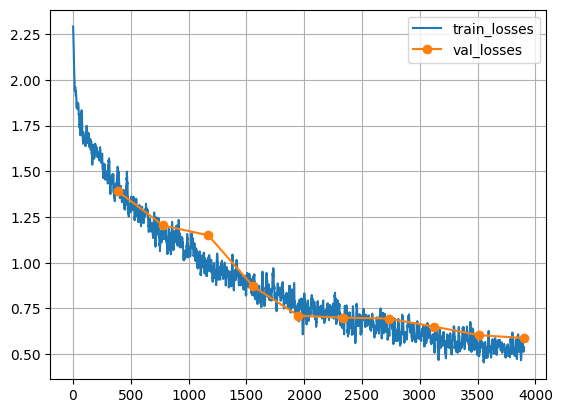

In [ ]:
start = time.time()
val_acc = get_acc(model_MobileNet, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses_MobileNet, val_losses_MobileNet)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


**answer**

### Explaining the 8-9x Speed-Up in MobileNet

Depthwise separable convolutions, the core building blocks of MobileNet, achieve significant computational efficiency compared to standard convolutions. Below, we calculate how the MobileNet paper derives the 8-9x speed-up by analyzing theoretical computations of FLOPs (floating-point operations per second) for both standard convolution and depthwise separable convolution.

#### FLOPs for Standard Convolution

A standard convolution filters and combines inputs in one step. The computational cost (FLOPs) for a standard convolution is:

$$
\text{FLOPs (Standard Convolution)} = DK \times DK \times M \times N \times DF \times DF
$$

Where:
- $ DK $: Kernel size (e.g., $ DK = 3 $ for $ 3 \times 3 $ kernel),
- $ M $: Number of input channels (input depth),
- $ N $: Number of output channels (output depth),
- $ DF $: Spatial size (width and height) of the input feature map.

#### FLOPs for Depthwise Separable Convolution

Depthwise separable convolution splits the operation into two steps:

1. **Depthwise Convolution:**
   Applies one filter per input channel. The computational cost is:
   $$
   \text{FLOPs (Depthwise Convolution)} = DK \times DK \times M \times DF \times DF
   $$

2. **Pointwise Convolution:**
   Combines the output of depthwise convolution using $ 1 \times 1 $ convolutions. The computational cost is:
   $$
   \text{FLOPs (Pointwise Convolution)} = M \times N \times DF \times DF
   $$

The total computational cost for depthwise separable convolution is:

$$
\text{FLOPs (Depthwise Separable Convolution)} = DK \times DK \times M \times DF \times DF + M \times N \times DF \times DF
$$

#### Speed-Up Factor

The speed-up factor is calculated as the ratio of FLOPs for standard convolution to depthwise separable convolution:

$$
\text{Speed-Up Factor} = \frac{\text{FLOPs (Standard Convolution)}}{\text{FLOPs (Depthwise Separable Convolution)}}
$$

Substitute the equations:

$$
\text{Speed-Up Factor} = \frac{DK \times DK \times M \times N \times DF \times DF}{DK \times DK \times M \times DF \times DF + M \times N \times DF \times DF}
$$

Factor out common terms $ M \times DF \times DF $:

$$
\text{Speed-Up Factor} = \frac{DK \times DK \times N}{DK \times DK + N}
$$

#### Example Calculation

For a $ 3 \times 3 $ kernel ($ DK = 3 $), $ M = 32 $ input channels, and $ N = 64 $ output channels:

1. **Standard Convolution FLOPs:**
   $$
   \text{FLOPs (Standard Convolution)} = 3 \times 3 \times 32 \times 64 \times DF \times DF = 552 \times DF \times DF
   $$

2. **Depthwise Separable Convolution FLOPs:**
   - Depthwise Convolution:
     $$
     \text{FLOPs (Depthwise Convolution)} = 3 \times 3 \times 32 \times DF \times DF = 288 \times DF \times DF
     $$
   - Pointwise Convolution:
     $$
     \text{FLOPs (Pointwise Convolution)} = 32 \times 64 \times DF \times DF = 2048 \times DF \times DF
     $$
   - Total:
     $$
     \text{FLOPs (Depthwise Separable Convolution)} = 288 \times DF \times DF + 2048 \times DF \times DF = 2336 \times DF \times DF
     $$

3. **Speed-Up Factor:**
   $$
   \text{Speed-Up Factor} = \frac{552 \times DF \times DF}{2336 \times DF \times DF} \approx 8.3
   $$


## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [ ]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [ ]:
epochs = 2

# TODO: train model
model_NormalCNN = NormalCNN(n_class=10).to(device)

start_time_NormalCNN = time.time()

train_losses_NormalCNN, val_losses_NormalCNN = train(train_loader, val_loader, model_NormalCNN, epochs, lr)

end_time_NormalCNN = time.time()
total_time_NormalCNN = end_time_NormalCNN - start_time_NormalCNN

print(f"Total Training Time: {total_time_NormalCNN:.2f} seconds")

Epoch 1/2
Train Loss (epoch avg): 1.9400, Accuracy: 27.60%
Val Loss (epoch avg): 2.0576, Accuracy: 26.98%
Epoch 2/2
Train Loss (epoch avg): 1.7039, Accuracy: 40.77%
Val Loss (epoch avg): 1.5359, Accuracy: 42.40%
Total Training Time: 615.17 seconds


Batch_size=128, epochs=2, lr=0.001
Val accuracy = 0.424
Process validation time: 36.9024 s


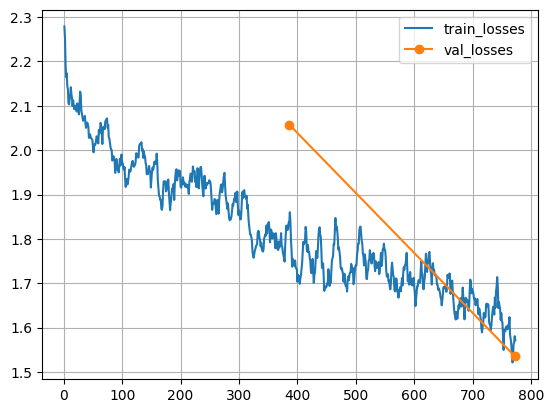

In [ ]:
start = time.time()
val_acc = get_acc(model_NormalCNN, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses_NormalCNN, val_losses_NormalCNN)

Compare speed of learning and validating in normal CNN vs MobileNet

**answer**
### Comparison of Learning and Validation Speed: MobileNet vs Normal CNN

#### Key Metrics:

| Metric                     | MobileNet          | Normal CNN         |
|----------------------------|--------------------|--------------------|
| **Epochs**                 | 10                | 2                  |
| **Batch Size**             | 128               | 128                |
| **Learning Rate (lr)**     | 0.001             | 0.001             |
| **Final Validation Accuracy** | 80.19%         | 42.40%            |
| **Total Training Time**    | 2139.08 seconds   | 615.17 seconds    |
| **Validation Time**        | 26.86 seconds     | 36.90 seconds     |

#### Insights:

1. **Speed of Training**:
   - MobileNet took approximately **2139 seconds** to complete 10 epochs, averaging ~213.9 seconds per epoch.
   - Normal CNN completed 2 epochs in **615.17 seconds**, averaging ~307.6 seconds per epoch.
   - **MobileNet is faster per epoch**, making it more efficient for training despite its complexity.

2. **Validation Time**:
   - MobileNet's validation process took **26.86 seconds**, which is **~27% faster** than Normal CNN's **36.90 seconds**.
   - MobileNet likely benefits from optimized architecture, resulting in faster inference.

3. **Accuracy**:
   - MobileNet achieved a **final validation accuracy of 80.19%**, significantly higher than Normal CNN's **42.40%**.
   - This demonstrates MobileNet's superior ability to learn features effectively.

4. **Learning Speed**:
   - MobileNet improved its validation accuracy from 48.57% (Epoch 1) to 80.19% (Epoch 10), indicating steady learning progress.
   - Normal CNN showed slower improvement, reaching only 42.40% after 2 epochs.

#### Conclusion:
MobileNet outperforms Normal CNN in terms of learning speed, validation time, and overall accuracy. It achieves higher performance while being computationally more efficient for both training and validation. This highlights the advantage of using MobileNet for tasks requiring both speed and accuracy.



In [ ]:
# TODO: compare number of parameters in these two models
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

mobilenet = MobileNet(n_class=10).to(device)
normalcnn = NormalCNN(n_class=10).to(device)

mobilenet_params = count_parameters(mobilenet)
normalcnn_params = count_parameters(normalcnn)

print(f"Number of parameters in MobileNet: {mobilenet_params}")
print(f"Number of parameters in NormalCNN: {normalcnn_params}")
print(f"Reduction Factor: {normalcnn_params / mobilenet_params:.2f}x")

Number of parameters in MobileNet: 3217226
Number of parameters in NormalCNN: 28279338
Reduction Factor: 8.79x


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [21]:
model = MobileNet(n_class=100).to(device)
#Todo:

# Load the pre-trained weights for the layers that match (excluding the final fc layer)
pretrained_dict = torch.load("model.pt")
model_dict = model.state_dict()

# Filter out unnecessary keys from the pretrained dict
filtered_pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and "fc" not in k}
model_dict.update(filtered_pretrained_dict)

# Load the updated state dict into the model
model.load_state_dict(model_dict)
print("Pre-trained weights loaded, excluding the final fc layer.")

Pre-trained weights loaded, excluding the final fc layer.


**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [22]:
freeze_up_to = 7
block_counter = 0

for name, module in model.model.named_children():
    if isinstance(module, nn.Sequential):
        block_counter += 1
        if block_counter <= freeze_up_to:
            for param in module.parameters():
                param.requires_grad = False

print("Frozen layers:")
for name, param in model.named_parameters():
    print(f"{name}: {'Frozen' if not param.requires_grad else 'Trainable'}")

Frozen layers:
model.0.0.weight: Frozen
model.0.1.weight: Frozen
model.0.1.bias: Frozen
model.1.0.weight: Frozen
model.1.1.weight: Frozen
model.1.1.bias: Frozen
model.1.3.weight: Frozen
model.1.4.weight: Frozen
model.1.4.bias: Frozen
model.2.0.weight: Frozen
model.2.1.weight: Frozen
model.2.1.bias: Frozen
model.2.3.weight: Frozen
model.2.4.weight: Frozen
model.2.4.bias: Frozen
model.3.0.weight: Frozen
model.3.1.weight: Frozen
model.3.1.bias: Frozen
model.3.3.weight: Frozen
model.3.4.weight: Frozen
model.3.4.bias: Frozen
model.4.0.weight: Frozen
model.4.1.weight: Frozen
model.4.1.bias: Frozen
model.4.3.weight: Frozen
model.4.4.weight: Frozen
model.4.4.bias: Frozen
model.5.0.weight: Frozen
model.5.1.weight: Frozen
model.5.1.bias: Frozen
model.5.3.weight: Frozen
model.5.4.weight: Frozen
model.5.4.bias: Frozen
model.6.0.weight: Frozen
model.6.1.weight: Frozen
model.6.1.bias: Frozen
model.6.3.weight: Frozen
model.6.4.weight: Frozen
model.6.4.bias: Frozen
model.7.0.weight: Trainable
model.7.

**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [23]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=True, num_workers=2)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 169M/169M [00:05<00:00, 29.0MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.


--- Displaying 16 images with shuffle=False ---


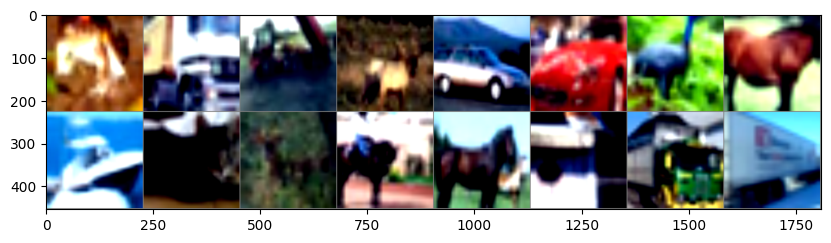

First 16 labels from the batch of 128 (shuffle=False): [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9]



--- Displaying augmented images with shuffle=False ---


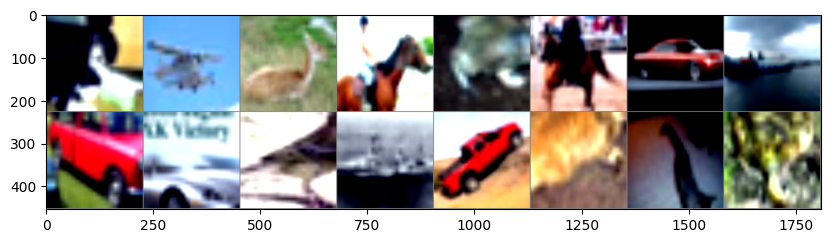

First 16 labels from the batch of 128 (after augmentation): [5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6]



--- Displaying 16 images with shuffle=True ---


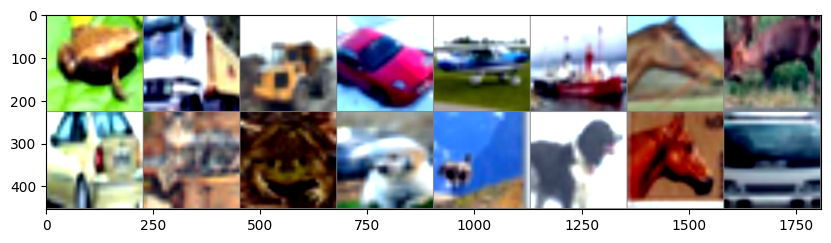

First 16 labels from the batch of 128 (shuffle=True): [6, 9, 9, 1, 0, 8, 7, 4, 1, 3, 6, 5, 2, 5, 7, 9]


In [26]:
# show some training images with shuffle=False and labels
train_loader_no_shuffle = DataLoader(train_subset, batch_size=128, shuffle=False)
data_iter_no_shuffle = iter(train_loader_no_shuffle)

images, labels = next(data_iter_no_shuffle)
print("\n--- Displaying 16 images with shuffle=False ---")
imshow(torchvision.utils.make_grid(images[:16], nrow=8))
print(f"First 16 labels from the batch of 128 (shuffle=False): {labels[:16].tolist()}")

# show them again to check the augmentation
images, labels = next(data_iter_no_shuffle)
print("\n--- Displaying augmented images with shuffle=False ---")
imshow(torchvision.utils.make_grid(images[:16], nrow=8))
print(f"First 16 labels from the batch of 128 (after augmentation): {labels[:16].tolist()}")

# Create train loader with shuffle=True
train_loader_shuffle = DataLoader(train_subset, batch_size=128, shuffle=True)
data_iter_shuffle = iter(train_loader_shuffle)

images, labels = next(data_iter_shuffle)
print("\n--- Displaying 16 images with shuffle=True ---")
imshow(torchvision.utils.make_grid(images[:16], nrow=8))
print(f"First 16 labels from the batch of 128 (shuffle=True): {labels[:16].tolist()}")

Do CIFAR10 and CIFAR100 use the same images but with diffrent labesl?(maybe you should search)

**answer**

The CIFAR-10 and CIFAR-100 datasets are both labeled subsets of the 80 Million Tiny Images dataset, curated to serve as benchmarks for image classification algorithms. While they share the same origin, they differ in the number of classes and the granularity of labeling.

**CIFAR-10:**
- Contains 60,000 images across 10 mutually exclusive classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.
- Each class comprises 6,000 images, with 5,000 for training and 1,000 for testing.

**CIFAR-100:**
- Also consists of 60,000 images but divided into 100 classes, each containing 600 images (500 for training and 100 for testing).
- These 100 classes are grouped into 20 superclasses, providing both "fine" labels (specific class) and "coarse" labels (superclass).

Despite originating from the same dataset, CIFAR-10 and CIFAR-100 do not use the exact same images. They were curated separately to focus on different classification tasks: CIFAR-10 for broader categories and CIFAR-100 for more specific subcategories. Therefore, while there might be some overlap in the types of objects depicted, the specific images and their labels differ between the two datasets.

*Reference: [CIFAR-10 and CIFAR-100 datasets](https://www.cs.toronto.edu/~kriz/cifar.html)*


Now train your model using your functions.

In [27]:
epochs = 7
lr = 2e-4
train_losses_model, val_losses_model = train(train_loader100, val_loader100, model, epochs, lr)

Epoch 1/7
Train Loss (epoch avg): 3.9931, Accuracy: 19.32%
Val Loss (epoch avg): 3.3668, Accuracy: 19.05%
Epoch 2/7
Train Loss (epoch avg): 3.1586, Accuracy: 28.69%
Val Loss (epoch avg): 2.9025, Accuracy: 27.01%
Epoch 3/7
Train Loss (epoch avg): 2.7773, Accuracy: 34.09%
Val Loss (epoch avg): 2.6240, Accuracy: 32.39%
Epoch 4/7
Train Loss (epoch avg): 2.5244, Accuracy: 37.41%
Val Loss (epoch avg): 2.4090, Accuracy: 36.51%
Epoch 5/7
Train Loss (epoch avg): 2.3527, Accuracy: 40.91%
Val Loss (epoch avg): 2.2607, Accuracy: 39.96%
Epoch 6/7
Train Loss (epoch avg): 2.2209, Accuracy: 43.86%
Val Loss (epoch avg): 2.1921, Accuracy: 41.14%
Epoch 7/7
Train Loss (epoch avg): 2.0986, Accuracy: 46.13%
Val Loss (epoch avg): 2.1469, Accuracy: 42.06%


Get some metrics and plot your losses.

Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 0.4206
Process validation time: 20.2918 s


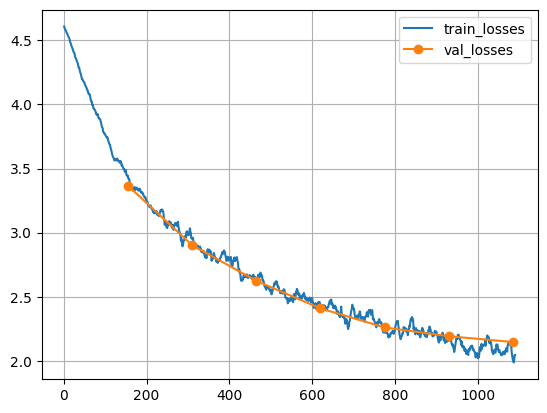

In [28]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses_model, val_losses_model)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

**answer**

### ReLU6 Activation Function

**What is ReLU6?**

ReLU6 is a variation of the standard ReLU (Rectified Linear Unit) activation function, defined as:

$$
\text{ReLU6}(x) = \min(\max(0, x), 6)
$$

This means that:
- For inputs $x \leq 0$, the output is 0.
- For inputs $0 < x < 6$, the output is $x$.
- For inputs $x \geq 6$, the output is capped at 6.

**Why do we use ReLU6?**

ReLU6 is particularly useful in scenarios where quantization is involved, such as mobile or embedded applications. The reasons include:

1. **Clipped Range for Stability:**
   - Capping the maximum value to 6 prevents the activation from growing excessively large, which can stabilize training and reduce the risk of numerical issues.

2. **Better Compatibility with Quantization:**
   - During post-training quantization, especially in low-precision formats (e.g., 8-bit integers), having activations bounded within a smaller range improves representability and reduces errors caused by quantization.

3. **Efficient Use in Resource-Constrained Devices:**
   - MobileNetV2, which is designed for mobile and embedded devices, employs ReLU6 because its bounded output aligns well with the constraints of these environments, ensuring efficient deployment.

In summary, ReLU6 is a modified ReLU that clips activations to a maximum value of 6, offering improved stability and compatibility for models deployed in hardware-constrained or quantized environments.


In [29]:

def conv_bn(inp, oup, stride):
    # Standard convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    # stride: stride for the convolution layer
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_1x1_bn(inp, oup):
    # 1x1 pointwise convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        # Inverted Residual block with optional skip connection
        # inp: input channels
        # oup: output channels
        # stride: stride for depthwise convolution
        # expand_ratio: multiplier for the hidden dimension size


        # Determine if a skip connection should be used


        # (only used when stride is 1 and input channels == output channels)


        # Calculate the number of hidden channels after expansion
        super(InvertedResidual, self).__init__()
        self.use_residual = stride == 1 and inp == oup
        hidden_dim = inp * expand_ratio

        layers = []
        if expand_ratio != 1:
            # Pointwise convolution to increase channel depth
            layers.append(conv_1x1_bn(inp, hidden_dim))

        # Depthwise convolution
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True)
        ])

        # Pointwise-linear convolution to reduce channel depth
        layers.append(nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, bias=False))
        layers.append(nn.BatchNorm2d(oup))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass with optional residual connection
        if self.use_residual:
            return x + self.conv(x)
        else:
            return self.conv(x)

Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [57]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=1.0):

        # building first layer

        # building inverted residual blocks

        # building last several layers

        # building classifier
        super(MobileNetV2, self).__init__()

        # Interverted residual settings (t: expansion factor, c: output channels, n: number of blocks, s: stride)
        interverted_residual_setting = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        assert input_size % 32 == 0

        input_channel = int(32 * width_multiplier)
        self.last_channel = int(1280 * width_multiplier) if width_multiplier > 1.0 else 640
        self.features = [conv_bn(3, input_channel, 2)]

        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(InvertedResidual(input_channel, output_channel, stride, t))
                input_channel = output_channel

        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        self.features.append(nn.AdaptiveAvgPool2d(1))
        self.features = nn.Sequential(*self.features)

        self.classifier = nn.Sequential(
            nn.Linear(self.last_channel, n_class)
        )

    def forward(self, x):
        """
        Forward pass through MobileNetV2.
        """
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

How did you create linear bottlenecks? How do they help?


**answer**

## Linear Bottlenecks in MobileNetV2

**How were linear bottlenecks created?**

Linear bottlenecks were implemented using the `InvertedResidual` block, which consists of three key stages:
1. **Pointwise Convolution (Expansion Layer):** Expands the number of channels by a factor (`expand_ratio`) to introduce more capacity for feature transformation.
2. **Depthwise Convolution:** Applies spatial convolutions independently for each channel, significantly reducing the computational cost.
3. **Pointwise Convolution (Projection Layer):** Reduces the number of channels back to the desired output size, often smaller than the expanded size.

The `InvertedResidual` block uses residual connections (skip connections) only when the input and output have the same shape, i.e., when the stride is `1` and the number of input channels equals the number of output channels.

**Why are linear bottlenecks helpful?**

Linear bottlenecks enable efficient feature representation by reducing the dimensions back to a "compressed" state after expanding for computation. The advantages include:
1. **Reduced Dimensionality:** After depthwise convolution, the linear projection layer ensures that redundant information is not propagated, preserving only the essential features.
2. **Increased Efficiency:** By keeping the input and output channels relatively small, computational complexity and memory usage are significantly reduced.
3. **Improved Gradient Flow:** The residual connections improve gradient flow during backpropagation, aiding optimization.

In summary, linear bottlenecks balance efficiency and expressiveness in MobileNetV2, making it suitable for resource-constrained environments such as mobile and embedded devices.


Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [58]:
model_MobileNetV2 = MobileNetV2(n_class=10).to(device)
epochs = 10
lr = 1e-3
train_losses_MobileNetV2, val_losses_MobileNetV2 = train(train_loader, val_loader, model_MobileNetV2, epochs, lr)

Epoch 1/10
Train Loss (epoch avg): 1.6292, Accuracy: 41.37%
Val Loss (epoch avg): 1.6887, Accuracy: 43.24%
Epoch 2/10
Train Loss (epoch avg): 1.2903, Accuracy: 52.48%
Val Loss (epoch avg): 1.2671, Accuracy: 54.41%
Epoch 3/10
Train Loss (epoch avg): 1.1201, Accuracy: 62.04%
Val Loss (epoch avg): 0.9940, Accuracy: 65.21%
Epoch 4/10
Train Loss (epoch avg): 0.9930, Accuracy: 64.94%
Val Loss (epoch avg): 0.9984, Accuracy: 65.31%
Epoch 5/10
Train Loss (epoch avg): 0.9056, Accuracy: 67.87%
Val Loss (epoch avg): 0.8799, Accuracy: 69.60%
Epoch 6/10
Train Loss (epoch avg): 0.8223, Accuracy: 72.67%
Val Loss (epoch avg): 0.7698, Accuracy: 72.95%
Epoch 7/10
Train Loss (epoch avg): 0.7602, Accuracy: 73.67%
Val Loss (epoch avg): 0.7308, Accuracy: 75.42%
Epoch 8/10
Train Loss (epoch avg): 0.7067, Accuracy: 76.20%
Val Loss (epoch avg): 0.6889, Accuracy: 76.38%
Epoch 9/10
Train Loss (epoch avg): 0.6612, Accuracy: 78.70%
Val Loss (epoch avg): 0.6518, Accuracy: 77.99%
Epoch 10/10
Train Loss (epoch avg): 0

Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.7892
Process validation time: 27.0943 s


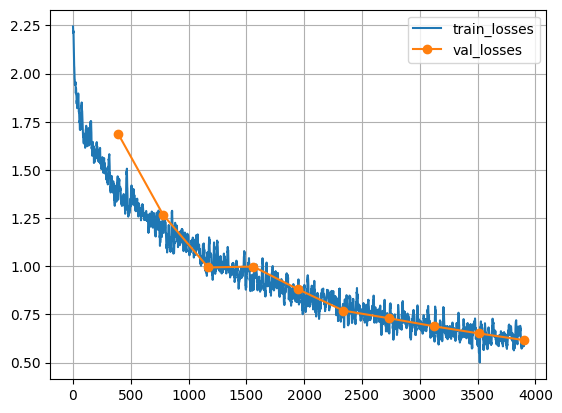

In [59]:
start = time.time()
val_acc = get_acc(model_MobileNetV2, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses_MobileNetV2, val_losses_MobileNetV2)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [56]:
# TODO
for width_multiplier in [i / 10.0 for i in range(1, 11)]:
    model = MobileNetV2(width_multiplier=width_multiplier)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"with {width_multiplier} width multiplier we got {num_params} parameters")

with 0.1 width multiplier we got 688414 parameters
with 0.2 width multiplier we got 769084 parameters
with 0.3 width multiplier we got 883870 parameters
with 0.4 width multiplier we got 1032948 parameters
with 0.5 width multiplier we got 1221768 parameters
with 0.6 width multiplier we got 1435470 parameters
with 0.7 width multiplier we got 1687444 parameters
with 0.8 width multiplier we got 1973414 parameters
with 0.9 width multiplier we got 2293796 parameters
with 1.0 width multiplier we got 2658792 parameters


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [83]:
import torch
import torch.nn as nn
import numpy as np

def _make_divisible(v, divisor):
    return max(divisor, int(v + divisor / 2) // divisor * divisor)

def conv_bn(inp, oup, stride):
    layers = [
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    ]
    return nn.Sequential(*layers)

def conv_1x1_bn(inp, oup):
    layers = [
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    ]
    return nn.Sequential(*layers)

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.identity = stride == 1 and inp == oup
        hidden_dim = round(inp * expand_ratio)
        if expand_ratio != 1:
            self.conv = nn.Sequential(
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup)
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup)
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=1.0):
        super(MobileNetV2, self).__init__()
        settings = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]
        divisor = 8 if width_multiplier >= 1.0 else 4
        input_channel = _make_divisible(32 * width_multiplier, divisor)
        last_channel = _make_divisible(1280 * width_multiplier, divisor) if width_multiplier > 1.0 else 640
        layers = [conv_bn(3, input_channel, 2)]
        for t, c, n, s in settings:
            out_ch = _make_divisible(c * width_multiplier, divisor)
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedResidual(input_channel, out_ch, stride, t))
                input_channel = out_ch
        layers += [conv_1x1_bn(input_channel, last_channel), nn.AdaptiveAvgPool2d(1)]
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Linear(last_channel, n_class)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2.0 / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)
        x = self.classifier(x)
        return x

In [84]:
MNv2_path = './MNv2WMmodel.pt'
# TODO
pretrained_model_MobileNetV2 = MobileNetV2(n_class=10, width_multiplier=0.5).to(device)
state = torch.load(MNv2_path, map_location=device)

model_state_dict = pretrained_model_MobileNetV2.state_dict()

filtered_state_dict = {k: v for k, v in state.items() if k in model_state_dict and model_state_dict[k].shape == v.shape}

pretrained_model_MobileNetV2.load_state_dict(filtered_state_dict, strict=False)

missing_keys = [k for k in model_state_dict if k not in filtered_state_dict]
unexpected_keys = [k for k in state if k not in model_state_dict]

In [85]:
start = time.time()
val_acc = get_acc(pretrained_model_MobileNetV2, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

Val accuracy = 0.7432
Process validation time: 24.6148 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

**answer**

### Explanation of Hyperparameter Effect on Number of Parameters

#### Effect of Width Multiplier ($ \alpha $) on Number of Parameters
The width multiplier ($ \alpha $) in MobileNet is a hyperparameter that reduces or increases the number of channels in each layer. Specifically, the number of channels in each layer is scaled by the width multiplier. If the base number of channels in a layer is $ C $, then with the width multiplier $ \alpha $, the effective number of channels becomes:

$$
C' = \alpha \cdot C
$$

Since the number of parameters in a convolutional layer is directly proportional to the product of input channels, output channels, and kernel size, scaling the channels by $ \alpha $ affects the total number of parameters as follows:

$$
\text{Parameters'} = \alpha^2 \cdot \text{Parameters}
$$

#### Formula to Predict Number of Parameters
Given the width multiplier $ \alpha $, the total number of parameters in the modified model ($ \text{Params'} $) can be calculated as:

$$
\text{Params'} = \alpha^2 \cdot \text{Base Parameters}
$$

Where:
- $ \text{Base Parameters} $ is the total number of parameters in the original model ($ \alpha = 1.0 $).

#### Example Calculation
For example, if the base model (with $ \alpha = 1.0 $) has $ 3.4 $ million parameters, and we apply $ \alpha = 0.75 $:

$$
\text{Params'} = (0.75)^2 \cdot 3.4M = 0.5625 \cdot 3.4M = 1.9125M
$$

#### Comparing Formula with Actual Numbers
If the theoretical calculation does not perfectly match the actual number of parameters:
1. **Rounding and Quantization Effects**: The actual number of channels in each layer is typically rounded to the nearest integer to ensure valid tensor dimensions, leading to slight deviations.
2. **Unchanged Layers**: Some layers (e.g., the first and last layers) may not scale with $ \alpha $, contributing to discrepancies.
3. **Bias Parameters**: If the model includes bias terms, these add parameters independently of the width multiplier, slightly altering the total.


Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

**answer**
### Resolution Multiplier: Impact on Speed and Parameters

#### What is the Resolution Multiplier?
The resolution multiplier scales the input image size during training and inference. For example, if the original input resolution is \( 224 \times 224 \), applying a resolution multiplier of \( r \) (e.g., \( r = 0.5 \)) results in a reduced resolution of \( (224 \cdot r) \times (224 \cdot r) \).

---

#### Effect on Model Speed
- **Impact on Computation**:
  - The computational cost of convolutional layers is proportional to the spatial dimensions of the input image. Specifically, for a convolutional layer, the computational cost is:
    \[
    \text{Computation} \propto H \times W \times K^2 \times C_{in} \times C_{out}
    \]
    Where \( H \) and \( W \) are the height and width of the input, \( K \) is the kernel size, and \( C_{in}, C_{out} \) are the input and output channels.
  - Reducing \( H \) and \( W \) via the resolution multiplier significantly reduces the number of operations, making the model faster.

- **Trade-Off**:
  - Lower resolution may result in a loss of fine-grained details, potentially reducing the model's accuracy for tasks requiring high spatial precision.

---

#### Effect on Number of Parameters
- **No Change in Parameters**:
  - The resolution multiplier does not directly affect the number of parameters in the model. Parameters are determined by the number of channels and kernel sizes, which remain fixed regardless of input resolution.
  - However, it indirectly affects memory usage, as smaller resolutions require fewer activations to be stored during training or inference.

---

#### Summary of Effects
| Aspect                  | Resolution Multiplier Effect   |
|-------------------------|--------------------------------|
| **Model Speed**         | **Faster**: Lower resolution reduces computational cost. |
| **Number of Parameters**| **Unchanged**: Parameters remain constant since layer configurations are unaffected. |
| **Accuracy**            | **Trade-off**: Lower resolution may decrease accuracy for tasks that rely on fine details. |



Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

**answer**
### Importance of the Number of Parameters in a Model

#### Why Do Parameters Matter?
1. **Memory Requirements**:
   - Each parameter in a model requires memory to store during training and inference.
   - Large models with millions or billions of parameters can exceed the memory limits of GPUs, especially when training on high-resolution data or large batch sizes.

2. **Computation Cost**:
   - Even with powerful GPUs, the number of parameters directly affects the number of operations (e.g., matrix multiplications) during forward and backward passes.
   - Larger models require more computational resources, increasing training and inference time.

3. **Overfitting**:
   - A higher number of parameters increases the capacity of a model, making it more prone to overfitting, especially when the dataset is small or noisy.
   - Reducing the number of parameters helps improve generalization, particularly in resource-constrained tasks.

4. **Deployment and Scalability**:
   - Many real-world applications require deploying models on edge devices (e.g., smartphones, IoT devices) or in environments with limited resources.
   - Models with fewer parameters are easier to deploy on devices with low memory and computational power, and they reduce latency during inference.

---

#### Are Parameters Still a Big Deal with GPUs?
1. **Advantages of GPUs**:
   - GPUs accelerate training and inference, allowing larger models to be used effectively.
   - Techniques like mixed-precision training, tensor cores, and distributed training further mitigate the computational challenges posed by large models.

2. **Limits of GPUs**:
   - **Energy Consumption**: Larger models consume significantly more energy, increasing operational costs and environmental impact.
   - **Latency Constraints**: In real-time applications (e.g., autonomous driving, speech recognition), latency is critical, and large models may not meet strict timing requirements, even with GPUs.
   - **Scalability Issues**: Not all tasks or organizations have access to cutting-edge GPUs, making parameter efficiency essential for broader accessibility.

---

#### When Is the Number of Parameters Important?
1. **On Edge Devices**:
   - Memory and computational limitations make parameter efficiency crucial.
   - Examples include models running on smartphones, drones, or embedded systems.

2. **For Scalability**:
   - In large-scale deployments (e.g., recommendation systems or search engines), the cumulative cost of using large models across billions of users becomes substantial.

3. **For Resource-Constrained Training**:
   - Smaller models are faster to train, enabling faster experimentation and iteration, especially for researchers and developers without access to large-scale hardware.




## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [36]:
import timm

# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, n_class=10)
teacher_model = teacher_model.to(device)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [37]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

Val accuracy = 0.0871
Process validation time: 24.3592 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [38]:
class DistillationLoss(nn.Module):
    """
    Custom loss function for knowledge distillation combining KL divergence
    and cross-entropy loss.

    Args:
        temperature (float): Temperature parameter for scaling logits.
        alpha (float): Weighting factor for distillation and classification loss.
    """
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction="batchmean")
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self,
                student_logits: torch.Tensor,
                teacher_logits: torch.Tensor,
                labels: torch.Tensor) -> torch.Tensor:
        """
        Compute the combined distillation and classification loss.

        Args:
            student_logits (torch.Tensor): Logits from the student model.
            teacher_logits (torch.Tensor): Logits from the teacher model.
            labels (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: The computed loss value.
        """
        soft_targets = nn.functional.softmax(teacher_logits / self.temperature, dim=1)
        student_log_probs = nn.functional.log_softmax(student_logits / self.temperature, dim=1)

        distillation_loss = self.kl_div(student_log_probs, soft_targets) * (self.temperature ** 2)

        classification_loss = self.ce_loss(student_logits, labels)

        total_loss = self.alpha * distillation_loss + (1 - self.alpha) * classification_loss
        return total_loss

def train_student(teacher: nn.Module,
                  student: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  test_loader: torch.utils.data.DataLoader,
                  device: torch.device,
                  epochs: int = 10,
                  lr: float = 0.01) -> None:
    """
    Train a student model using knowledge distillation.

    Args:
        teacher (nn.Module): Pre-trained teacher model.
        student (nn.Module): Student model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        device (torch.device): Device to perform training on (CPU or GPU).
        epochs (int): Number of training epochs. Default is 10.
        lr (float): Learning rate for the optimizer. Default is 0.01.
    """
    teacher.to(device).eval()
    student.to(device)

    criterion = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs):
        student.train()
        total_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.no_grad():
                teacher_logits = teacher(inputs)

            student_logits = student(inputs)

            loss = criterion(student_logits, teacher_logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

        evaluate(student, test_loader, device)

def evaluate(model: nn.Module, data_loader: torch.utils.data.DataLoader, device: torch.device) -> None:
    """
    Evaluate the model on a dataset.

    Args:
        model (nn.Module): Model to evaluate.
        data_loader (torch.utils.data.DataLoader): DataLoader for evaluation data.
        device (torch.device): Device to perform evaluation on.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

Train it for one epoch to just check if it works.

In [39]:
student = MobileNetV2(n_class=10)

train_student(teacher_model, student, train_loader, val_loader, device, epochs=1, lr=0.001)

Epoch 1/1, Loss: 1.0002
Test Accuracy: 48.39%


What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?


**answer**
## Potential Trade-Offs of High vs. Low Values of $ \alpha $ in `DistillationLoss`

### 1. **High Value of $ \alpha $ (e.g., $ \alpha = 0.9 $)**
A high value of $ \alpha $ places more emphasis on the distillation (KL divergence) loss, which encourages the student model to align more closely with the teacher model's softened predictions.

- **Advantages**:
  - **Better Alignment with Teacher**: The student model is more likely to mimic the teacher's knowledge, including its inductive biases and learned generalizations.
  - **Useful for Complex Tasks**: For tasks where the teacher has rich, nuanced knowledge (e.g., soft probabilities capturing inter-class relationships), this alignment can help the student learn subtle patterns.
  - **Smooth Decision Boundaries**: The student model may learn smoother decision boundaries, which can lead to better generalization in certain cases.

- **Disadvantages**:
  - **Overfitting to Teacher**: The student may overly rely on the teacher's knowledge and fail to adapt to the target task if the teacher's predictions are not perfectly aligned with the data distribution.
  - **Reduced Adaptability**: If the target task diverges from the teacher's training data, the student may struggle to generalize because it focuses too much on mimicking the teacher.

---

### 2. **Low Value of $ \alpha $ (e.g., $ \alpha = 0.1 $)**
A low value of $ \alpha $ shifts the emphasis toward the classification (cross-entropy) loss, which focuses on aligning the student model's predictions with the ground-truth labels.

- **Advantages**:
  - **Better Adaptation to Target Task**: The student model is more driven by the true labels, making it better suited for tasks where the teacher's knowledge is less relevant or not entirely accurate for the new task.
  - **Robustness to Teacher Errors**: If the teacher's predictions are noisy or suboptimal, a low $ \alpha $ reduces the impact of these errors on the student's training.

- **Disadvantages**:
  - **Weaker Knowledge Transfer**: The student may fail to effectively utilize the teacher's richer knowledge, such as soft probabilities and inter-class relationships.
  - **Sharper Decision Boundaries**: Overemphasis on hard labels can lead to sharper decision boundaries, which may reduce generalization, especially in noisy or ambiguous datasets.

---

### 3. **Impact on Generalization and Alignment**
- **High $ \alpha $:**
  - **Generalization**: May improve generalization if the teacher's knowledge is highly relevant to the target task.
  - **Alignment**: Strong alignment with the teacher's knowledge, leading to greater similarity in behavior between the teacher and student.

- **Low $ \alpha $:**
  - **Generalization**: May improve generalization if the teacher's predictions are suboptimal or the task diverges from the teacher's training domain.
  - **Alignment**: Weaker alignment with the teacher, leading to more independence in the student's behavior.

---

### 4. **Choosing the Right $ \alpha $**
The ideal value of $ \alpha $ depends on the task and the quality of the teacher's knowledge:
- For tasks closely aligned with the teacher's training, a **higher $ \alpha $** is beneficial to leverage the teacher's knowledge.
- For tasks that diverge significantly from the teacher's domain, a **lower $ \alpha $** allows the student to focus on the ground-truth labels.

In practice, hyperparameter tuning should be performed to find the best balance between distillation and classification losses for the specific task.


## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018